In [1]:
DATA_PATH = '/root/Internship-Valeo/Project/data/COCO/'

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras import layers as tfl
from tensorflow_addons.image import transform as H_transform
import os
from models.utils import box_nms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models.homographies import *
from utils.tools import dict_update
from plot_utils import plot_imgs

In [3]:
train_images = os.listdir(DATA_PATH+'anntrain2014')
val_images = os.listdir(DATA_PATH+'annval2014')
mask_train_images = os.listdir(DATA_PATH+'anntrain2014')
mask_val_images = os.listdir(DATA_PATH+'annval2014')

In [4]:
image_shape = (240, 320,1)

In [5]:
model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
#             'detection_threshold': 0.001, # 1/65
            'detection_threshold': 0.015,
            'descriptor_size': 256,
            'batch_size': 64,
            'eval_batch_size': 50,
            'epochs': 25,
            'learning_rate': 0.001,
            'kernel_reg': 0.,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 4,
            'top_k': 0,
            'train_iter': 50000,
            'eval_iter': 200,
            'validation_interval': 1000,
            'seed': 0,
            'filter_counts': 0,
            #'save_interval': 5000,
            #'keep_checkpoints': 20
    }

In [6]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size, kernel_initializer='he_uniform',
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [7]:
def shared_encoder(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    return conv8

In [8]:
def detector_head(inputs, model_config):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    x = vgg_block(inputs, 256, 3, 'conv1',
                      activation=tf.nn.relu, **params_conv)
    x = vgg_block(x, 1+pow(model_config['grid_size'], 2), 1, 'conv2',
                      activation=None, **params_conv)

    prob = tf.nn.softmax(x, axis=cindex)
    # Strip the extra “no interest point” dustbin
    prob = prob[:, :-1, :, :] if cfirst else prob[:, :, :, :-1]
    prob = tf.nn.depth_to_space(
              prob, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    prob = tf.squeeze(prob, axis=cindex)
    return {'logits': x, 'prob': prob}

In [9]:
def detector_loss(keypoint_map, logits, model_config, valid_mask=None):
    if model_config['data_format'] == 'channels_first':
        logits = tf.transpose(logits, [0, 2, 3, 1])
    # Convert the boolean labels to indices including the "no interest point" dustbin
    labels = keypoint_map#[..., tf.newaxis]  # for GPU
    labels = tf.cast(labels, tf.float32)
    labels = tf.nn.space_to_depth(labels, model_config['grid_size'])
    shape = tf.concat([tf.shape(labels)[:3], [1]], axis=0)
    labels = tf.concat([2*labels, tf.ones(shape)], 3)
    # Add a small random matrix to randomly break ties in argmax
    labels = tf.argmax(labels + tf.random.uniform(tf.shape(labels), 0, 0.1), axis=3)
    # Mask the pixels if bordering artifacts appear
    valid_mask = tf.ones_like(keypoint_map) if valid_mask is None else valid_mask
#     valid_mask = valid_mask[..., tf.newaxis]  # for GPU
    valid_mask = tf.cast(valid_mask, tf.float32)
    valid_mask = tf.nn.space_to_depth(valid_mask, model_config['grid_size'])
    valid_mask = tf.math.reduce_prod(valid_mask, axis=3)  # AND along the channel dim
    valid_mask = tf.cast(valid_mask, tf.int64)
#     labels = labels * valid_mask
#     loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits, weights=valid_mask)
    return loss

In [10]:
def model_metrics(y_true, y_pred, valid_mask):
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    pred = tf.expand_dims(pred, axis = 3)
    pred = valid_mask * pred
    labels = y_true
    precision = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(pred)
    recall = tf.math.reduce_sum(pred * labels) / tf.math.reduce_sum(labels)
#     return {'precision': precision, 'recall': recall}
    return precision

In [11]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        metrics = self.metrics_fn(inputs[0], inputs[1]['prob'], valid_mask = inputs[2])
        self.add_loss(tf.math.reduce_mean(loss))
        self.add_metric(metrics, name = 'precision')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape = (240, 320, 1)):
    images_inputs = Input(shape = input_shape, name = 'images')
    valid_masks_inputs = Input(shape = input_shape, name = 'valid_masks')
    warped_points_inputs = Input(shape = input_shape, name = 'warped_points')
    
    encoder_output = shared_encoder(images_inputs, model_config=model_config)
    output = detector_head(encoder_output, model_config=model_config)
    
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [12]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [13]:
# model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-synth-aug-080222')
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-100222-latest')

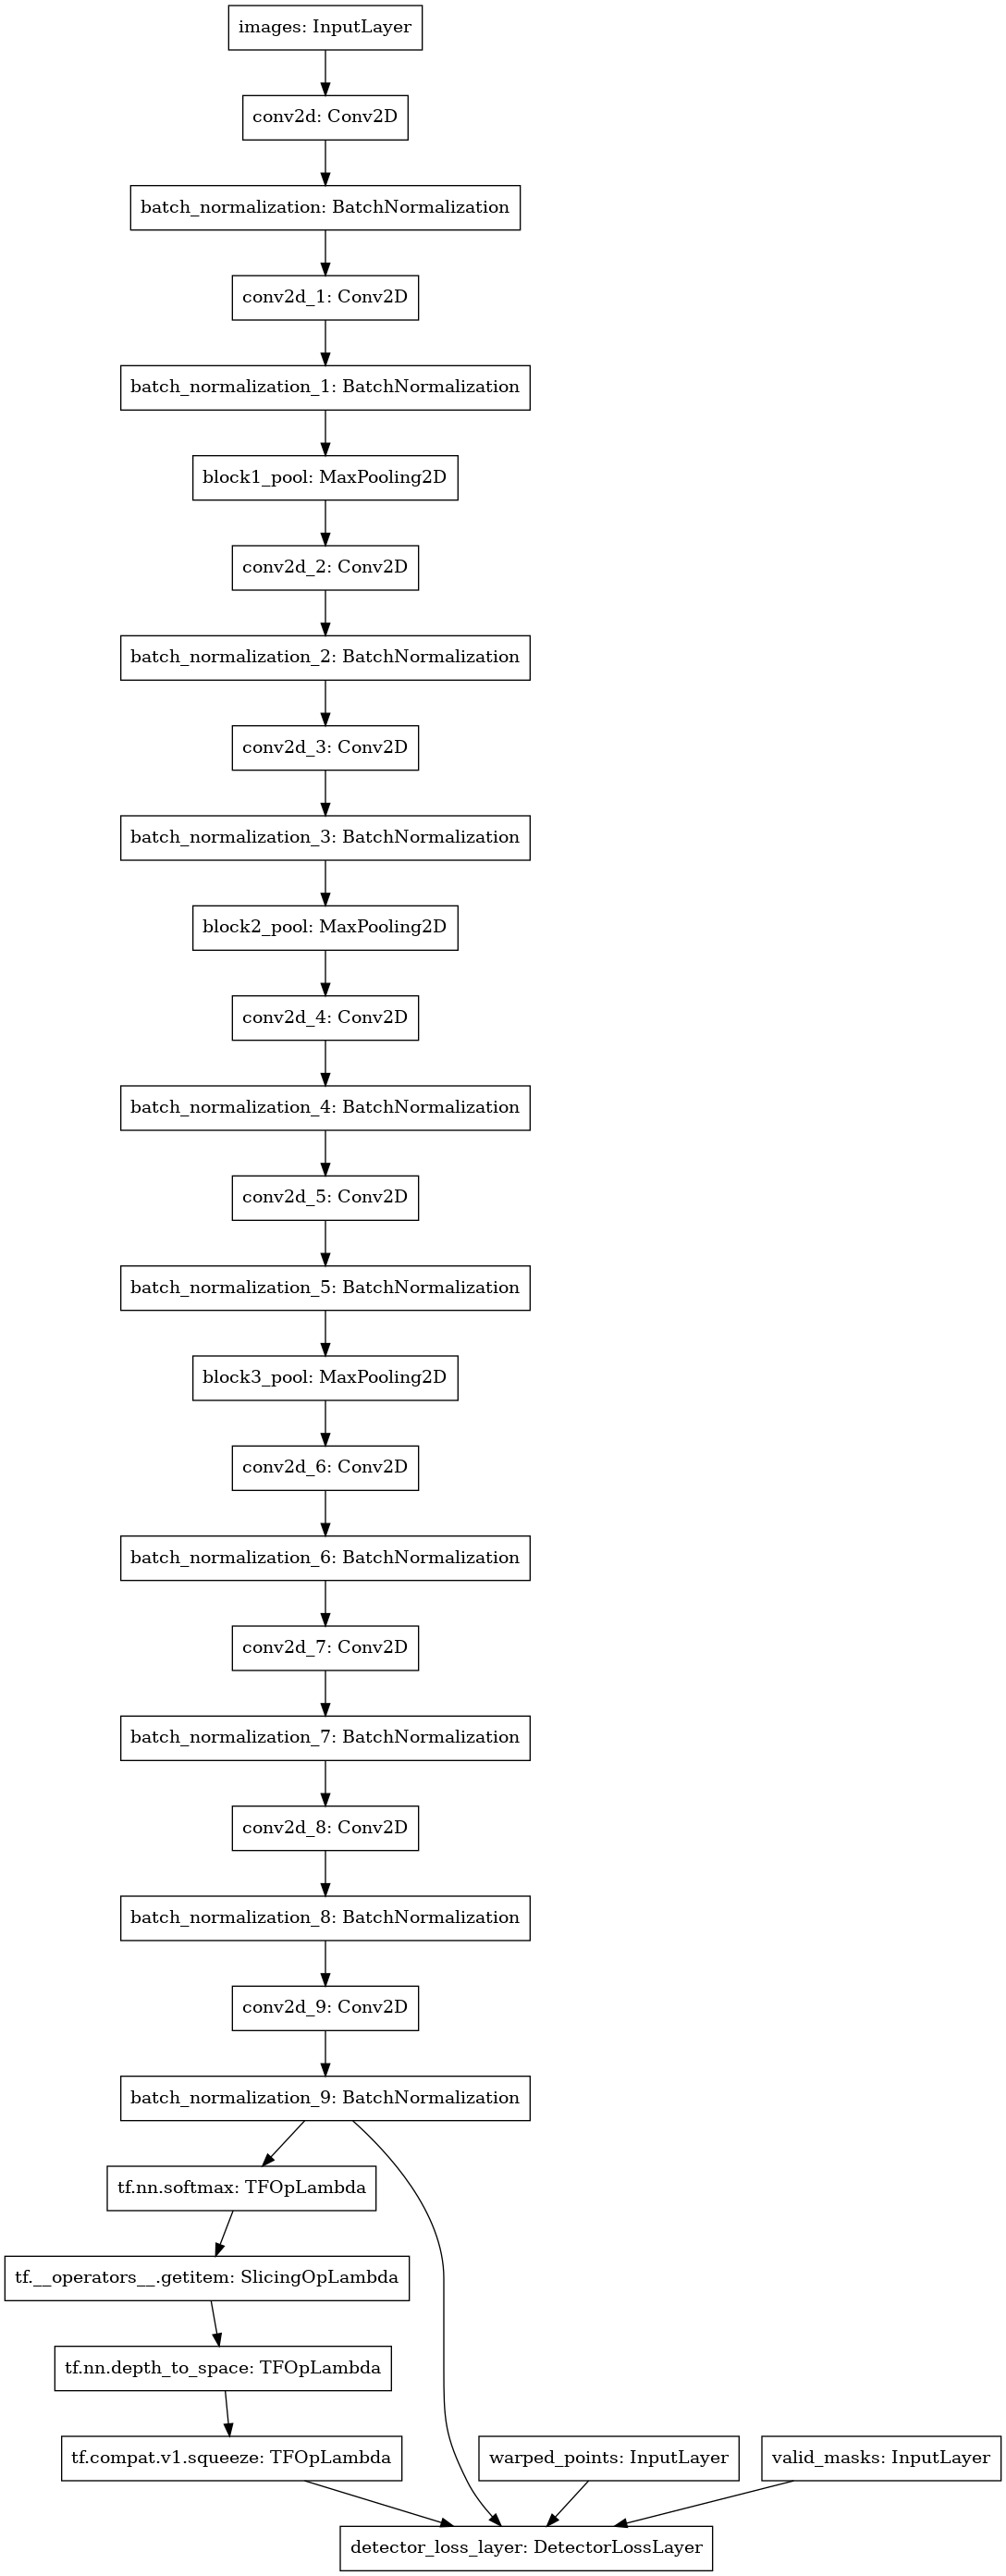

In [14]:
keras.utils.plot_model(model, rankdir="TB", expand_nested=True)

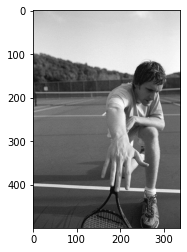

In [15]:
I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',train_images[0]),0)
plt.imshow(I, cmap = 'gray')

In [16]:
valid_mask = np.ones((1, 240,320,1))
keypoints_map =  np.zeros((1, 240,320,1))

In [17]:
I.shape

(500, 339)

In [18]:
I = cv2.resize(I,(320, 240))
I = np.expand_dims(I, axis = 0)
I = np.expand_dims(I, axis = 3)

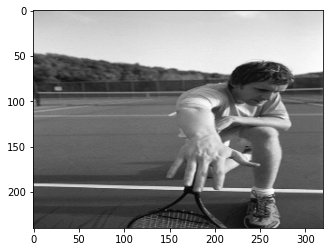

In [19]:
plt.imshow(I[0], cmap = 'gray')

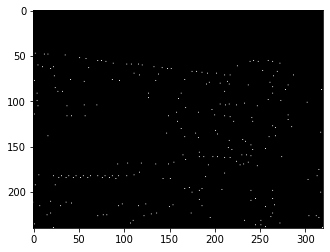

In [20]:
prob = model.get_layer('tf.compat.v1.squeeze').output
m = keras.models.Model(inputs = model.input[0], outputs = prob)

y_pred = m.predict(I)

if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred)
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
    
# pred = pred * valid_mask # multiplied with valid masks

plt.imshow(pred[0], cmap = 'gray')

# Homographic Adaptation

In [21]:
HA = homography_adaptation(I, m)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


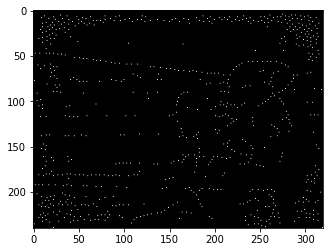

In [22]:
if model_config['nms']:
    prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), HA['prob'])
    pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.int32)
    
# pred = pred * x[1] # multiplication by valid mask commented out as it's not a warped image

plt.imshow(pred[0], cmap = 'gray')

In [23]:
def draw_keypoints(img, corners, color, s = 4):
    keypoints = [cv2.KeyPoint(c[1]*s, c[0]*s, 1) for c in np.stack(corners).T]
    img = cv2.resize(img, None, fx=s, fy=s)
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

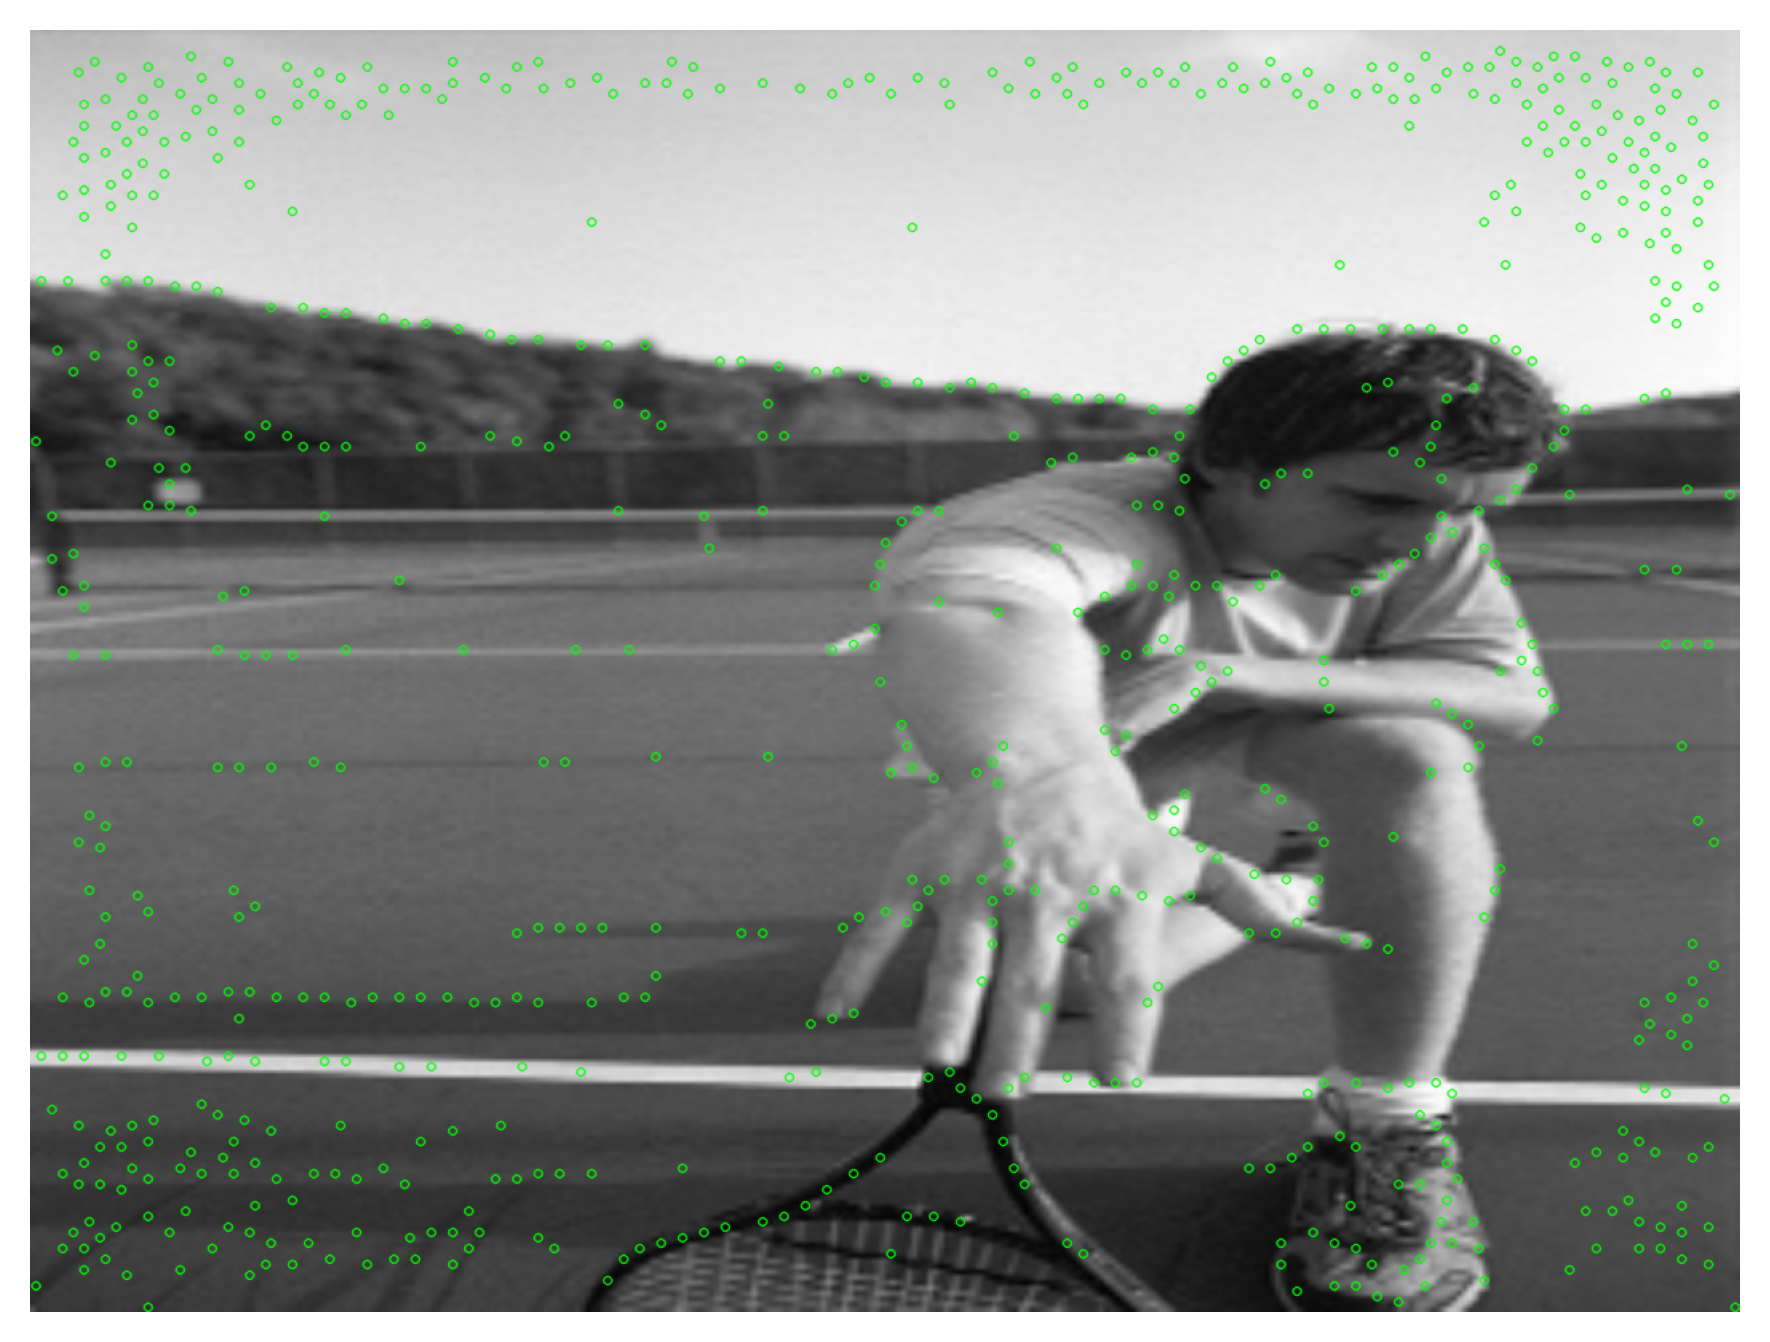

In [24]:
Img = I[0]
plot_imgs([draw_keypoints(Img[..., 0], tf.cast(np.where(pred[0]), tf.float32), (0, 255, 0))/255.], dpi=300)
# plot_imgs([HA['counts'][0]>model_config['filter_counts']], cmap='gray', dpi=300)

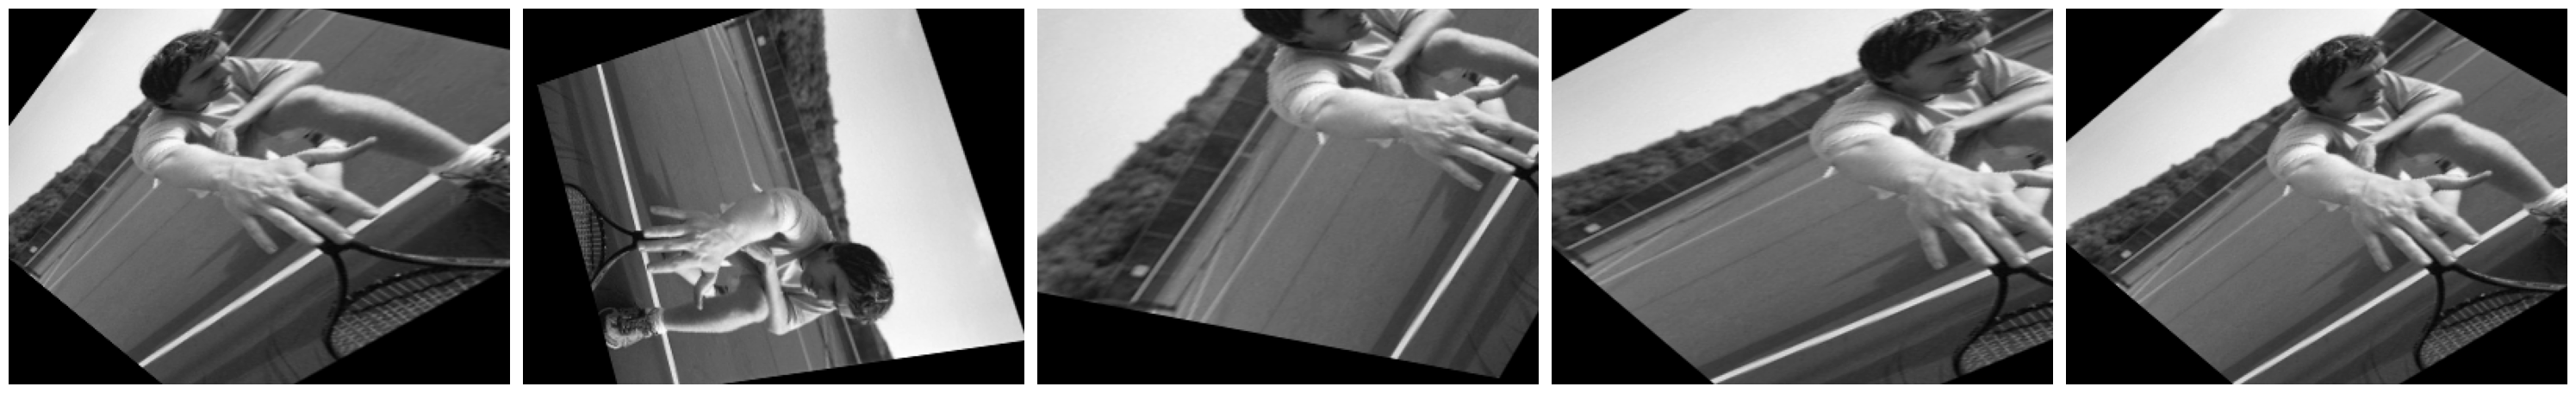

In [25]:
plot_imgs([HA['input_images'][0][..., 0, i+1]/255 for i in range(5)], cmap='gray')

# Detections on train images with homographic adaptation

In [26]:
# Repeat when a detector has been trained again

for file_path in train_images:
    I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
    I = cv2.resize(I,(320, 240))
    I = np.expand_dims(I, axis = 0)
    I = np.expand_dims(I, axis = 3)
    
    HA = homography_adaptation(I, m)
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), HA['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.int32)
    

    kp = np.argwhere(pred[0])
    np.save(os.path.join(DATA_PATH, 'pointstrain2014',file_path), kp)

# Detections on val images with homographic adaptation

In [27]:
# Repeat when a detector has been trained again

for file_path in val_images:
    I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
    I = cv2.resize(I,(320, 240))
    I = np.expand_dims(I, axis = 0)
    I = np.expand_dims(I, axis = 3)
    
    HA = homography_adaptation(I, m)
    if model_config['nms']:
        prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), HA['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.int32)
    

    kp = np.argwhere(pred[0])
    np.save(os.path.join(DATA_PATH, 'pointsval2014',file_path), kp)

# Detections on train images without homographic adaptation

In [ ]:
# Repeat when a detector has been trained again

# for file_path in train_images:
#     I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
#     I = cv2.resize(I,(320, 240))
#     I = np.expand_dims(I, axis = 0)
#     I = np.expand_dims(I, axis = 3)
#     result = model.predict(I)
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
#     labels = tf.argmax(result['logits'], axis =cindex)
#     one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
#     # Strip the extra “no interest point” dustbin
#     one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
#     one_hot = tf.nn.depth_to_space(
#               one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     one_hot = tf.squeeze(one_hot, axis=cindex)
#     one_hot = np.argwhere(one_hot[0])
#     np.save(os.path.join(DATA_PATH, 'pointstrain2014',file_path), one_hot)

# Detections on val images without homographic adaptation

In [ ]:
# Repeat when a detector has been trained again

# for file_path in val_images:
#     I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
#     I = cv2.resize(I,(320, 240))
#     I = np.expand_dims(I, axis = 0)
#     I = np.expand_dims(I, axis = 3)
#     result = model.predict(I)
    
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel
#     labels = tf.argmax(result['logits'], axis =cindex)
#     one_hot = tf.one_hot(labels, depth = 1+pow(model_config['grid_size'], 2))
#     # Strip the extra “no interest point” dustbin
#     one_hot = one_hot[:, :-1, :, :] if cfirst else one_hot[:, :, :, :-1]
#     one_hot = tf.nn.depth_to_space(
#               one_hot, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     one_hot = tf.squeeze(one_hot, axis=cindex)
#     one_hot = np.argwhere(one_hot[0])
#     np.save(os.path.join(DATA_PATH, 'pointsval2014',file_path), one_hot)

# Save homographies, warped images, warped masks, warped points

In [28]:
config = {
            'add_augmentation_to_test_set': False,
            'num_parallel_calls': 10,
            'preprocessing': {
                'resize': [240, 320],
                'blur_size': 11,
            },
            'augmentation': {
                'photometric': {
                    'enable': True,
                    'primitives': 'all',
                    'params': {
                        'random_brightness': {'max_abs_change': 75},
                        'random_contrast': {'strength_range': [0.3, 1.8]},
                        'additive_gaussian_noise': {'stddev_range': [0, 15]},
                        'additive_speckle_noise': {'prob_range': [0, 0.0035]},
                        'additive_shade':{
                            'transparency_range': [-0.5, 0.8],
                            'kernel_size_range': [50, 100]},
                        'motion_blur': {'max_kernel_size': 7}},
                    'random_order': True,
                },
                'homographic': {
                    'enable': True,
                    'params': {
                        'translation': True,
                        'rotation': True,
                        'scaling': True,
                        'perspective': True,
                        'scaling_amplitude': 0.2,
                        'perspective_amplitude_x': 0.2,
                        'perspective_amplitude_y': 0.2,
                        'patch_ratio': 0.8,
                        'max_angle': 1.57,  # 3.14
                        'allow_artifacts': True,
                        'translation_overflow': 0.05,
                        'valid_border_margin': 3,
                    },
                },
            }
    }

In [29]:
image_shape = (240, 320)

In [30]:
for file_path in train_images:
    # read image
    I = cv2.imread(os.path.join(DATA_PATH, 'anntrain2014',file_path),0)
    # resize image
    I = cv2.resize(I,(320, 240))
    # add homography
    homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
    path = os.path.join(DATA_PATH, 'homographies_train', file_path)
    np.save(path, homography)
    # generate warped_image and save
    warped_image = H_transform(I, homography, interpolation='BILINEAR')
    cv2.imwrite(os.path.join(DATA_PATH, 'warptrain2014',file_path), np.array(warped_image))
    # read mask
    M = cv2.imread(os.path.join(DATA_PATH, 'masktrain2014',file_path),0)
    # warp mask 
    warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
    cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_train2014',file_path), np.array(warped_mask_image))
    # compute valid mask
    valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['params']['valid_border_margin'])
    # read key points map
    points = np.load(os.path.join(DATA_PATH, 'pointstrain2014',file_path+'.npy'))
    warped_points = warp_points(points, homography)
#     warped_points = tf.minimum(warped_points, tf.cast(image_shape, tf.float32)-1)
#     warped_points = np.round(warped_points).astype(int)
    # save warped interest points
    np.save(os.path.join(DATA_PATH, 'warped_pointstrain2014',file_path), warped_points)

In [31]:
for file_path in val_images:
    # read image
    I = cv2.imread(os.path.join(DATA_PATH, 'annval2014',file_path),0)
    # resize image
    I = cv2.resize(I,(320, 240))
    # add homography
    homography = sample_homography(image_shape, config['augmentation']['homographic']['params'])[0]
    path = os.path.join(DATA_PATH, 'homographies_val', file_path)
    np.save(path, homography)
    # generate warped_image and save
    warped_image = H_transform(I, homography, interpolation='BILINEAR')
    cv2.imwrite(os.path.join(DATA_PATH, 'warpval2014',file_path), np.array(warped_image))
    # read mask
    M = cv2.imread(os.path.join(DATA_PATH, 'maskval2014',file_path),0)
    # warp mask 
    warped_mask_image = H_transform(M, homography, interpolation='NEAREST')
    cv2.imwrite(os.path.join(DATA_PATH, 'warp_mask_val2014',file_path), np.array(warped_mask_image))
    # compute valid mask
    valid_mask = compute_valid_mask(image_shape, homography,
                                         config['augmentation']['homographic']['params']['valid_border_margin'])
    # read key points map
    points = np.load(os.path.join(DATA_PATH, 'pointsval2014',file_path+'.npy'))
    warped_points = warp_points(points, homography)
#     warped_points = tf.minimum(warped_points, tf.cast(image_shape, tf.float32)-1)
#     warped_points = np.round(warped_points).astype(int)
    # save warped interest points
    np.save(os.path.join(DATA_PATH, 'warped_pointsval2014',file_path), warped_points)